In [1]:
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

import time
import zipfile
import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
#from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [47]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


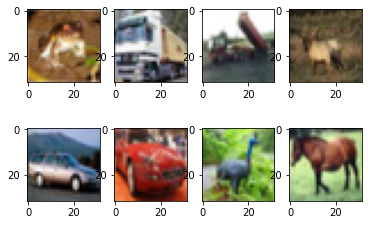

In [3]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [ ]:
start = time.time()
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [ ]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

In [ ]:
dura = time.time() - start
print("The training time of the baseline model is ", dura)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [ ]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

In [48]:
# Data Splitting and preprocessing
x_train1=imgs[:7000,:,:,:]
x_train1 = tf.cast(x_train1, dtype='float32')/255.0
y_train1 = noisy_labels[:7000]
y_clean1 = clean_labels[:7000]

x_train2= imgs[10000:,:,:,:]
x_train2= tf.cast(x_train2, dtype='float32')/255.0
y_train2 = noisy_labels[10000:]

x_test=imgs[7000:10000,:,:,:]
y_test = noisy_labels[7000:10000]
y_clean2=clean_labels[7000:10000]

### 2.2. Model I

In [53]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

# Model_I generator is for generating an empty untrained modelI structure
def modelI_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32,(3,3),activation ='relu', input_shape=(32,32,3)),
        tf.keras.layers.MaxPooling2D((2,2)),
        #tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(64,(3,3),activation ='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
        #tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(64,(3,3),activation ='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation = 'relu'),
        #tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation = 'softmax')        
                                ])
    return model

#Time keeper
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

#Start Training
modelI=modelI_generator()
start_time = time.time()
modelI.compile(optimizer='Adam',
                 loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics = ['accuracy'])
modelI.summary()
early_stop = tf.keras.callbacks.EarlyStopping(patience=3)
history = modelI.fit(x_train2, y_train2, batch_size= 10,epochs=10,
          validation_split= 0.2, callbacks=[early_stop, time_callback])
print("--- model took %s seconds ---" % (time.time() - start_time))

# Note:Method model_I is only for single/one picture prediction (not for a dataset)
def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    #reshape image into rank 4 tensor
    #takes in one image of (32, 32, 3) and returns label prediction

    image = tf.reshape(image, ((1,) + image.shape))
    predictions = modelI.predict(image)
    
    return np.argmax(predictions)

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_77 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_78 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_79 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 flatten_26 (Flatten)        (None, 1024)            

KeyboardInterrupt: 

### 2.3. Model II

Before building model II, we built a CNN model for label correction. For the data using to build this model, we choose from the 10000 clean label. We use 7000

In [72]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10,activation='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

fitted_model = model.fit(x_train1, y_clean1,batch_size=64, epochs=20, validation_data=(x_test, y_clean2))


Epoch 1/20


C:\Users\Administrator\anaconda3\envs\eods-s22\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


110/110 [==============================] - 5s 40ms/step - loss: 2.0502 - accuracy: 0.2296 - val_loss: 189.3788 - val_accuracy: 0.2580
Epoch 2/20
110/110 [==============================] - 4s 37ms/step - loss: 1.7025 - accuracy: 0.3761 - val_loss: 321.6587 - val_accuracy: 0.2543
Epoch 3/20
110/110 [==============================] - 4s 36ms/step - loss: 1.5624 - accuracy: 0.4283 - val_loss: 258.6745 - val_accuracy: 0.3363
Epoch 4/20
110/110 [==============================] - 4s 37ms/step - loss: 1.4577 - accuracy: 0.4663 - val_loss: 246.7174 - val_accuracy: 0.3503
Epoch 5/20
110/110 [==============================] - 4s 37ms/step - loss: 1.3774 - accuracy: 0.5043 - val_loss: 359.0487 - val_accuracy: 0.3167
Epoch 6/20
110/110 [==============================] - 4s 39ms/step - loss: 1.3015 - accuracy: 0.5310 - val_loss: 212.3617 - val_accuracy: 0.4153
Epoch 7/20
110/110 [==============================] - 4s 39ms/step - loss: 1.2317 - accuracy: 0.5579 - val_loss: 266.6616 - val_accuracy: 0.4

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_98 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_66 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_99 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_100 (Conv2D)         (None, 4, 4, 64)          36928     
                                                                 
 flatten_33 (Flatten)        (None, 1024)            

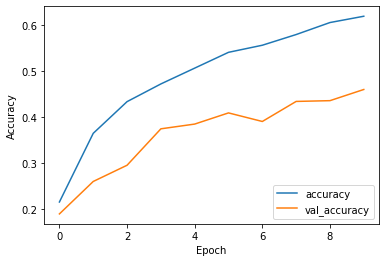

In [65]:
model.summary()
plt.plot(fitted_model.history['accuracy'], label='accuracy')
plt.plot(fitted_model.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

In [69]:
# classify 40000 images for cleaned label
predictions_array=model.predict(x_train2)

new_labels = np.empty(len(predictions_array),dtype=int)
for i in range(len(predictions_array)):
    new_labels[i]=np.argmax(predictions_array[i])
display(new_labels)

array([1, 6, 6, ..., 9, 8, 0])

In [ ]:
#combine 10000 clean labels and 40000 cleaned labels and save to csv
#cleaned_labels = np.hstack((clean_labels,predict_labels))
#display(cleaned_labels)
#np.savetxt("~/data/cleaned_labels.csv", cleaned_labels, delimiter=",")

In [70]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]
modelII = modelI_generator()

start_time = time.time()        
modelII.compile(optimizer='adam',
                 loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics = ['accuracy'])
    
early_stop = tf.keras.callbacks.EarlyStopping(patience=3)
time_callback = TimeHistory()

history = modelII.fit(x_train2, new_labels, batch_size=64,epochs=5,
          validation_split= 0.2, callbacks=[early_stop, time_callback])

def model_II(img):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    img = tf.reshape(img, ((1,) + img.shape))
    predictions = modelII.predict(img)
    
    return np.argmax(predictions)

Epoch 1/5
500/500 [==============================] - 18s 34ms/step - loss: 1.3265 - accuracy: 0.5148 - val_loss: 0.9789 - val_accuracy: 0.6348
Epoch 2/5
500/500 [==============================] - 18s 36ms/step - loss: 0.7919 - accuracy: 0.6998 - val_loss: 0.6883 - val_accuracy: 0.7390
Epoch 3/5
500/500 [==============================] - 18s 37ms/step - loss: 0.6401 - accuracy: 0.7533 - val_loss: 0.6264 - val_accuracy: 0.7551
Epoch 4/5
500/500 [==============================] - 19s 37ms/step - loss: 0.5540 - accuracy: 0.7853 - val_loss: 0.5640 - val_accuracy: 0.7753
Epoch 5/5
500/500 [==============================] - 18s 37ms/step - loss: 0.5156 - accuracy: 0.7984 - val_loss: 0.4974 - val_accuracy: 0.8061


## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [51]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [ ]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.

In [71]:
#Evaluation for model II
start = time.time()
evaluation(model_II, y_clean2, x_test)
end = time.time()
print("--- model took %s seconds ---" % (end-start))

              precision    recall  f1-score   support

           0       0.43      0.54      0.48       312
           1       0.46      0.80      0.58       316
           2       0.40      0.31      0.35       313
           3       0.42      0.20      0.27       320
           4       0.52      0.22      0.31       280
           5       0.38      0.55      0.45       266
           6       0.81      0.29      0.43       305
           7       0.66      0.46      0.54       299
           8       0.46      0.76      0.57       315
           9       0.40      0.46      0.43       274

    accuracy                           0.46      3000
   macro avg       0.49      0.46      0.44      3000
weighted avg       0.49      0.46      0.44      3000

--- model took 172.72735595703125 seconds ---


In [45]:
#Evaluation for model II on hidden 10000
from keras.datasets import cifar10

(X_train,Y_train),(X_test,Y_test)=cifar10.load_data()

In [62]:
#Evaluation for model II
start = time.time()
evaluation(model_II, Y_test, X_test)
end = time.time()
print("--- model took %s seconds ---" % (end-start))

KeyboardInterrupt: 